In [2]:
import wmfdata as wmf

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [3]:
%matplotlib inline

# Create

In [23]:
wmf.hive.run(
    """
    create table neilpquinn.new_editors(
        user_name string,
        wiki string,
        cohort string,
        1st_month_edits bigint,
        2nd_month_edits bigint
    )
    -- This allows us to delete data later on (e.g. in case of duplicate inserts)
    TBLPROPERTIES ("transactional"="true")
    """
)

# Update

In [24]:
# To-do: We take the metric month and look backwards. But this results in censored data
# for months under 30 days (February).

# Start included, end excluded. Have to set the end back a couple of months to ensure we only get uncensored data.
START = "2001-01"
END = "2018-03"

SNAPSHOT = "2018-04"

In [25]:
# Be careful not to insert duplicate data. Primary keys were introduced in Hive 2.1.0,
# so until we're running that there's no built-in way to stop duplicates.
wmf.hive.run(
    """
    insert into table neilpquinn.new_editors
    select 
        1st_month.user_name as user_name,
        1st_month.wiki as wiki,
        1st_month.cohort as cohort,
        1st_month.edits as 1st_month_edits,
        coalesce(2nd_month.edits, 0) as 2nd_month_edits
    from (
        select
            event_user_text as user_name,
            wiki_db as wiki,
            substr(event_user_creation_timestamp, 0, 7) as cohort,
            count(*) as edits
        from wmf.mediawiki_history
        where
            snapshot = "{snapshot}" and
            event_entity = "revision" and
            event_type = "create" and
            event_user_is_created_by_system = 0 and
            event_user_creation_timestamp >= "{start}" and
            event_user_creation_timestamp < "{end}" and
            unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") <
                (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60))
        group by event_user_text, event_user_creation_timestamp, wiki_db
        ) 1st_month
    left join (
        select
            event_user_text as user_name,
            wiki_db as wiki,
            substr(event_user_creation_timestamp, 0, 7) as cohort,
            count(*) as edits
        from wmf.mediawiki_history
        where
            snapshot = "{snapshot}" and
            event_entity = "revision" and
            event_type = "create" and
            event_user_is_created_by_system = 0 and
            event_user_creation_timestamp >= "{start}" and
            event_user_creation_timestamp < "{end}" and
            unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") >=
                (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60)) and
            unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") <
                (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (60*24*60*60))
            group by event_user_text, event_user_creation_timestamp, wiki_db
        ) 2nd_month
    on
        (1st_month.user_name = 2nd_month.user_name and
        1st_month.wiki = 2nd_month.wiki and
        1st_month.cohort = 2nd_month.cohort)
    """.format(
        snapshot = SNAPSHOT,
        start = START,
        end = END
    )
)

# Validate

In [64]:
# Check to make sure no cohorts have duplicated data
new_eds = wmf.hive.run(
    """
    select cohort, count(*)
    from neilpquinn.new_editors
    group by cohort
    order by cohort asc
    limit 500
    """
)

In [ ]:
new_eds["_c1"] = 

/home/neilpquinn-wmf/venv/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f083dee15c0> has a label of '_c1' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


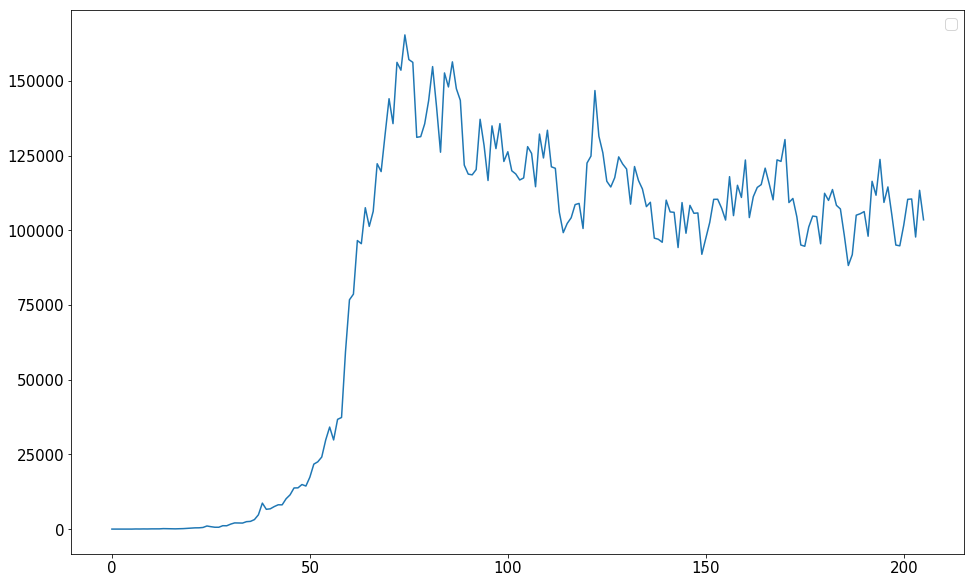

In [67]:
CUR_COHORT = "2018-02-01"
new_eds.plot();